# Introduction

### **Professional Machine Learning Engineer Certification**

The Professional Machine Learning Engineer Certification by Google Cloud was released to the public on October 15th, 2020. According to the official [examination page](https://cloud.google.com/certification/machine-learning-engineer):

> A Professional Machine Learning Engineer designs, builds, and productionizes ML models to solve business challenges using Google Cloud technologies and knowledge of proven ML models and techniques. The ML Engineer is proficient in all aspects of model architecture, data pipeline interaction, and metrics interpretation and needs familiarity with application development, infrastructure management, data engineering, and security.





In this session, we'll be looking at the following:

1. The nature of an exam question and how it can be tackled.
2. Building an appropriate solution with the identified tools.
3. Deploying the produced solution on Google Cloud.

# The Problem

Today, we'll be building an AI-powered model capable of assigning one of five emojis to a given comment.

## The Problem Statement

Let's set the stage with an exam-level question:

*Heartfelt is a modern startup working on a new website comment system. It uses AI to generate one of five emotions from each comment (Happy, Funny, Scared, Angry, Sad). It then shows the number of each of the five reactions above the comment section.*

```
  21341 😃     21 😂     0 😨     2 😠     5 😭
_____________________________________________________

Sathish
  This honestly made my day!                                      😃

Pranay
  We really need more good news in the world, like this...        😃

Maitreyi
  Awesome!                                                        😃
```

*They have obtained and labeled a large number of comments from their existing non-AI based system and are looking to upgrade to the new solution within a year. Their in-house ML engineers have designed a proprietary model, and apart from using the cloud for training and deploying, they also want to be able to fine-tune it for accuracy.*

*What is the best way to build, tune, and deploy the model?*


## The Proposed Solution

1. Files containing the labelled (Comment, Category) pairs are stored in a **Google Cloud Storage** bucket.
2. **AI Platform Notebooks** will be used to access and process the data stored in the GCS bucket, rapidly prototype to find the best architecture, and train the model on a small portion of the dataset.
3. **AI Platform Jobs** will be used to train the identified model architecture on the entirety of the dataset, performing hyperparameter tuning along the way. The trained model will be versioned and stored in a GCS bucket.
4. **AI Platform Prediction** will be used to deploy the stored model. It allows for versioning, phased rollouts, and easy access to the model with REST API calls.
5. **Google Cloud Storage** hosts the trained model, which is accessed by AI Platform Prediction.





# The Solution

## Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_hub as hub

import matplotlib.pyplot as plt

import csv
import random

## Obtaining and Processing the Data

The dataset used here was entirely created by me. Let us take a moment to understand it.

There are 200 sentence-label pairs, 40 in each of 5 categories- Happy (0), Funny (1), Scared (2), Angry (3), and Sad (4). The first thing we need to do is define a method that converts between these numbers and the emojis.

In [2]:
list_of_emojis = ['😃','😂','😨','😠','😭']

def label_to_emoji(label):
  return list_of_emojis[label]

Now, we open the dataset and create two lists- one to store the strings (data) and the other to store the labels (labels).


In [3]:
# The next cell is only for use on GCP

In [4]:
import gcsfs

def prepare_data(filename):

  data = []
  labels = []
    
  if filename.startswith('gs://'):
    fs = gcsfs.GCSFileSystem(project='durable-will-291417')
    with fs.open(filename, "rt", encoding="ascii") as my_dataset:
        
      reader = csv.reader(my_dataset, delimiter=',')
      for row in reader:
        data.append(row[0])
        labels.append(int(row[1]))
        
  else:
    with open(filename) as my_dataset:

      reader = csv.reader(my_dataset, delimiter=',')
      for row in reader:
        data.append(row[0])
        labels.append(int(row[1]))

  return (data, labels)

In [5]:
# The next cell is only for use on Colab

In [6]:
# def prepare_data(filename):
#   data = []
#   labels = []

#   with open(filename) as my_dataset:

#     reader = csv.reader(my_dataset, delimiter=',')

#     for row in reader:

#       data.append(row[0])
#       labels.append(int(row[1]))

#   return (data, labels)

In [7]:
data, labels = prepare_data('heartfelt_dataset.csv')

The next block of code is used to shuffle these pairs while maintaining the order between them. We first split the data into 2 buckets - 150 in Train and 50 in Test. We then print 10 examples of both train and test data, along with the emojified values of the labels that represent them.

In [8]:
def shuffle_data(data, labels):

  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  list_to_shuffle = list(zip(data, labels))
  random.shuffle(list_to_shuffle)

  shuffled_data, shuffled_labels = zip(*list_to_shuffle)

  X_train = shuffled_data[0:150]
  Y_train = shuffled_labels[0:150]

  X_test = shuffled_data[150:200]
  Y_test = shuffled_labels[150:200]

  return (X_train, Y_train, X_test, Y_test)

In [9]:
X_train, Y_train, X_test, Y_test = shuffle_data(data, labels)

print ("Examples of training data:\n")

for i in range(10):
  print ("  {} : {}".format(X_train[i], label_to_emoji(Y_train[i])))

print ('')

print ("Examples of testing data:\n")

for i in range(10):
  print ("  {} : {}".format(X_test[i], label_to_emoji(Y_test[i])))

Examples of training data:

  Get the hell out of here! : 😠
  Disgusting. : 😠
  Yuck, he ate his own poop? : 😂
  Hope this ends soon. : 😭
  Is no one going to talk about how funny this was? : 😂
  My blood is boiling right now. : 😠
  Are you insane? : 😠
  Comedians need to be paid more! : 😂
  Must watch! : 😃
  That's right, always treat others with respect. : 😃

Examples of testing data:

  How pathetic. : 😨
  Can we throw these people in prison? : 😠
  It's like you were born for comedy. : 😂
  Is there a reason you're still here? : 😠
  She did not just say that! : 😠
  My team lost today. : 😭
  You need to be more careful! : 😭
  Rolling on the floor here. : 😂
  Those laughs are infectious! : 😂
  Yes! : 😃


Sanity checks are essential. They help us ensure that the data was not corrupted during the ingestion and provide some insight into the data's nature. Let us look at how many samples we have in Train and Test, along with the lengths of the longest and shortest strings in the dataset.

In [10]:
print ("The training set contains {} examples with {} labels\n".format(len(X_train), len(Y_train)))
print ("The testing set contains {} examples with {} labels\n".format(len(X_test), len(Y_test)))

min_len = len(min(X_train, key=len).split())
print ("The length of the shortest sentence is {}\n".format(min_len))

max_len = len(max(X_train, key=len).split())
print ("The length of the longest sentence is {}\n".format(max_len))

The training set contains 150 examples with 150 labels

The testing set contains 50 examples with 50 labels

The length of the shortest sentence is 1

The length of the longest sentence is 12



Okay, perfect.

## Constructing the Model


The *model* is the algorithm we develop to be able to solve an AI problem. Without getting too deep into the architecture here, the basic idea is that we're building a model capable of learning the relationship between *embedded* forms of the sentences and their corresponding emojis.

In [11]:
def Model():

  model = keras.Sequential([keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                            keras.layers.LSTM(units=128, return_sequences=True),
                            keras.layers.Dropout(rate=0.5),
                            keras.layers.LSTM(units=128, return_sequences=False),
                            keras.layers.Dropout(rate=0.5),
                            keras.layers.Dense(units=5),
                            keras.layers.Activation("softmax")])
  
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  
  return model

In [12]:
model = Model()

## Training Locally

Before we can think about training this model on our data, there are some things we need to take care of.

One-hot encoding involves modifying the labels, such that each label is a vector containing precisely one 1 and all other 0s, uniquely corresponding to the emoji it represents. The one-hot encoded forms are as follows:

0 becomes [1, 0, 0, 0, 0] (Happy)

1 becomes [0, 1, 0, 0, 0] (Funny)

2 becomes [0, 0, 1, 0, 0] (Scared)

3 becomes [0, 0, 0, 1, 0] (Angry)

4 becomes [0, 0, 0, 0, 1] (Sad)

The method below one-hot encodes the training and test labels and shows you a sample.

In [13]:
def convert_to_one_hot(labels):
  return tf.one_hot(labels, 5)

In [14]:
Y_train_oh = convert_to_one_hot(labels=Y_train)
Y_test_oh = convert_to_one_hot(labels=Y_test)

pos_to_test = 75
print ("{} : {} (The numeric value of this is {})".format(X_train[pos_to_test], label_to_emoji(Y_train[pos_to_test]), Y_train[pos_to_test]))
print (Y_train_oh[pos_to_test])

I am genuinely terrified now. : 😨 (The numeric value of this is 2)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


A sentence embedding is a vector representation of the sentence, where it's translated into a unique combination of N numbers (dimensions). Here, we are using N=128 dimensions. Apart from uniquely identifying a sentence, these numbers also carry relative semantic meaning, which allows the model to learn relationships between similar sentences.

For example, if the model was trained on the sentence "I like puppies" and the word "adore" never appeared anywhere in the training set, it can still learn to infer that "I adore puppies" should produce the same emoji. As for these embeddings themselves, you can create your own from massively large datasets or use one that someone else created. Here, we're going with the latter. The embeddings used here come from TensorFlow Hub (more in the references section below).

Look at how the sentence "I love you." becomes a vector of 128 numbers.


In [15]:
def load_hub_module():
  embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2")
  return embed

In [16]:
embed = load_hub_module()
print ("I love you.\n\n{}".format(embed(["I love you."])))

I love you.

[[ 0.06720316 -0.05019467  0.19946459  0.12020276  0.14881054 -0.00456426
  -0.05057551 -0.04841431 -0.19195782 -0.02451784 -0.12093704 -0.2852198
  -0.00294066 -0.05971586  0.14719391  0.07701718  0.02095461 -0.06760143
   0.15468313  0.01675761 -0.03760123 -0.05660797 -0.00736546  0.08649251
  -0.08041847 -0.1563163   0.03294101  0.07168686 -0.11695939 -0.1823932
  -0.08472857 -0.0987467  -0.03675023 -0.01732922  0.22283307 -0.05921975
  -0.01329962 -0.05822768  0.06824754  0.17341426 -0.07891089 -0.23081318
  -0.10878634 -0.30201977  0.0608683   0.08700971 -0.05933066 -0.13618678
  -0.02547742  0.18084317  0.07031292 -0.11094392  0.04854394  0.15780668
  -0.06359842 -0.09194843  0.02376433 -0.14330299  0.03715428 -0.06878028
  -0.14734161  0.19417918  0.0823964   0.05661403 -0.05078657 -0.06345925
   0.10933136  0.04545296  0.14868559 -0.03175765 -0.39383692  0.14416008
   0.07267258 -0.11527298  0.09845851  0.01740749  0.08343427 -0.14131157
   0.03251657  0.23407583  

Now for the fun part! We pass the embedded training (and testing) data, the one-hot encoded training (and testing) labels, and specify a few other things- like how long we want the training to take place and the number of examples to train with each time.

In [17]:
def train_model(model, embed, X_train, Y_train_oh, X_test, Y_test_oh, num_epochs=100, batch_size=10, shuffle=True):
  return model.fit(embed(X_train),
                      Y_train_oh,
                      epochs = num_epochs,
                      batch_size = batch_size,
                      shuffle=shuffle,
                      validation_data=(embed(X_test), Y_test_oh))

In [18]:
history = train_model(model, embed, X_train, Y_train_oh, X_test, Y_test_oh)

Epoch 1/100
15/15 [==============================] - 1s 84ms/step - loss: 1.6105 - accuracy: 0.1800 - val_loss: 1.6114 - val_accuracy: 0.1400
Epoch 2/100
15/15 [==============================] - 0s 9ms/step - loss: 1.6049 - accuracy: 0.2933 - val_loss: 1.6124 - val_accuracy: 0.1800
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 1.6000 - accuracy: 0.3067 - val_loss: 1.6134 - val_accuracy: 0.1800
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 1.5969 - accuracy: 0.3200 - val_loss: 1.6149 - val_accuracy: 0.2600
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 1.5884 - accuracy: 0.4733 - val_loss: 1.6140 - val_accuracy: 0.3200
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 1.5757 - accuracy: 0.4267 - val_loss: 1.6117 - val_accuracy: 0.2800
Epoch 7/100
15/15 [==============================] - 0s 8ms/step - loss: 1.5535 - accuracy: 0.4333 - val_loss: 1.6043 - val_accuracy: 0.2800
Epoch 8/100


If you don't understand this, don't worry. We're just having a look at how our model has been composed.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (10, 1, 128)              0         
_________________________________________________________________
lstm (LSTM)                  (10, 1, 128)              131584    
_________________________________________________________________
dropout (Dropout)            (10, 1, 128)              0         
_________________________________________________________________
lstm_1 (LSTM)                (10, 128)                 131584    
_________________________________________________________________
dropout_1 (Dropout)          (10, 128)                 0         
_________________________________________________________________
dense (Dense)                (10, 5)                   645       
_________________________________________________________________
activation (Activation)      (10, 5)                   0

The plot shown here indicates how the model did in both Training, as well as in Validation. As you can see, the Validation Accuracy stopped growing after about 40-50% (though the Train Accuracy went up to 100%). Can you think of why? Hint: Lack of data on our end.

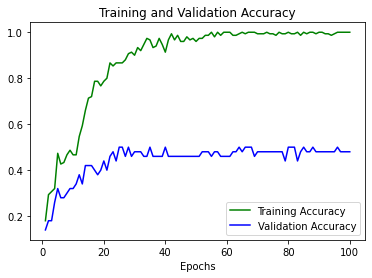

In [20]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1,101)

plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_val, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')

plt.legend()
plt.show()

## Predicting Locally

And we're done! Time to see if our model works.


In [21]:
def predict(list_of_input_sentences, mode='deploy'):

  '''
  Input: A list of sentences and a mode. 'Test' mode is used to simply generate 
         and print the string-emoji pairs to make sure everything works properly.
         'Deploy' mode is used when we want to return a prediction for one
         sentence at a time.

  Task: Use the model built to make emoji predictions with the given sentences.
  
  '''

  number_of_input_sentences = len(list_of_input_sentences)
  embedded_list = embed(list_of_input_sentences)
  prediction = model.predict(embedded_list)

  if mode == 'test':
    for i in range(number_of_input_sentences):
      print ("{} : {}".format(list_of_input_sentences[i], label_to_emoji(tf.argmax(prediction[i]))))

  elif mode == 'deploy':
    return tf.argmax(prediction[0])

Here are some relatively straightforward sentences. If our model gets these too badly wrong, there might be a problem.

In [22]:
predict(["I feel like dancing today!",
         "Now THAT was funny!",
         "I am terrified.",
         "This isn't fair!",
         "That hurts!"], mode='test')

I feel like dancing today! : 😃
Now THAT was funny! : 😂
I am terrified. : 😨
This isn't fair! : 😠
That hurts! : 😭


Everything works fine. Now let's try to build out a mini-version of the comment system.

In [23]:
class Comments:

  def __init__(self):

    self.comments = []
    self.generated_emojis = []

    self.num_happy = 0
    self.num_laugh = 0
    self.num_scared=0
    self.num_angry=0
    self.num_sad = 0

  def input_sentences(self, list_of_input_sentences):

    '''
    Input: A list of comments.

    Task: Generates emojis from the comments and saves the comment-emoji pairs.

    '''

    for sentence in list_of_input_sentences:

      self.comments.append(sentence)

      result = predict([sentence])

      self.generated_emojis.append(label_to_emoji(result))

      if result == 0:
        self.num_happy = self.num_happy + 1
      elif result == 1:
        self.num_laugh = self.num_laugh + 1
      elif result == 2:
        self.num_scared = self.num_scared + 1
      elif result == 3:
        self.num_angry = self.num_angry + 1
      elif result == 4:
        self.num_sad = self.num_sad + 1

  def display_comments(self):

    '''
    Task: Displays the entire comment system.
    
    '''
      
    print("{} 😃   {} 😂   {} 😨   {} 😠   {} 😭".format(self.num_happy, self.num_laugh, self.num_scared, self.num_angry, self.num_sad))
    print ("___________________________________\n\n")

    comment_emoji_pairs = zip(self.comments, self.generated_emojis)

    for comment, emoji in comment_emoji_pairs:
      print ("{:<75}{:>1}\n".format(comment, emoji))

In [24]:
comment_system = Comments()

In [25]:
comment_system.input_sentences(["The darkness is closing all around us.",
                                "This is upsetting.",
                                "Your smile is beautiful!"])

comment_system.display_comments()

1 😃   0 😂   2 😨   0 😠   0 😭
___________________________________


The darkness is closing all around us.                                     😨

This is upsetting.                                                         😨

Your smile is beautiful!                                                   😃



In [26]:
comment_system.input_sentences(["Are you mad?",
                                "Hilarious!"])

comment_system.display_comments()

2 😃   0 😂   2 😨   1 😠   0 😭
___________________________________


The darkness is closing all around us.                                     😨

This is upsetting.                                                         😨

Your smile is beautiful!                                                   😃

Are you mad?                                                               😠

Hilarious!                                                                 😃



## Training With AI Platform Jobs

Now that we've built our model, and are happy with the performance, let's talk about training on AI Platform Jobs. Our notebook was used for rapid prototyping, and while we can (and have) produced a working model here, it may be better to train on Jobs.

1. Jobs can be orchestrated within an AI pipeline.

2. They run on temporarily allotted hardware, and unlike notebooks that are expensive to keep running, you're only charged for a job while it is running.

3. You can use AI Platform's hyperparameter tuning service to find the best set of hyperparameters to use with your model.

The approach is as follows:

1. Train on a small dataset within your notebook (prototyping), and then with the entire dataset within Jobs. In this case, our dataset was anyway small, so this doesn't make a difference to us.

2. When satisfied with the model code, build a Python package containing a task.py file (will be used only to read the hyperparameters passed as command-line arguments) and a model.py file (includes all the model code and program logic).

3. Train the model with Jobs and save the model in Google Cloud Storage.

First, we make a folder called *trainer*.

In [27]:
%mkdir train
%mkdir train/trainer

Let's start by writing an \__ init __.py file. This is required to make the folder be treated as a Python package.

In [28]:
%%writefile train/trainer/__init__.py
# This exists only as a formality

Writing train/trainer/__init__.py


Next, let's write the model.py file.

In [29]:
%%writefile train/trainer/model.py
import tensorflow as tf
import keras
import tensorflow_hub as hub

import matplotlib.pyplot as plt

import csv
import random

import os

list_of_emojis = ['😃','😂','😨','😠','😭']

def label_to_emoji(label):
  return list_of_emojis[label]

#-------------------------------------------------------------------------------

# This block is only for use on GCP

import gcsfs

def prepare_data(filename):

  data = []
  labels = []
    
  if filename.startswith('gs://'):
    fs = gcsfs.GCSFileSystem(project='durable-will-291417')
    with fs.open(filename, "rt", encoding="ascii") as my_dataset:
        
      reader = csv.reader(my_dataset, delimiter=',')
      for row in reader:
        data.append(row[0])
        labels.append(int(row[1]))
        
  else:
    with open(filename) as my_dataset:

      reader = csv.reader(my_dataset, delimiter=',')
      for row in reader:
        data.append(row[0])
        labels.append(int(row[1]))

  return (data, labels)

#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------

# This block is only for use on Colab

# def prepare_data(filename):
#   data = []
#   labels = []

#   with open(filename) as my_dataset:

#     reader = csv.reader(my_dataset, delimiter=',')

#     for row in reader:

#       data.append(row[0])
#       labels.append(int(row[1]))

#   return (data, labels)

#-------------------------------------------------------------------------------

def shuffle_data(data, labels):

  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  list_to_shuffle = list(zip(data, labels))
  random.shuffle(list_to_shuffle)

  shuffled_data, shuffled_labels = zip(*list_to_shuffle)

  X_train = shuffled_data[0:150]
  Y_train = shuffled_labels[0:150]

  X_test = shuffled_data[150:200]
  Y_test = shuffled_labels[150:200]

  return (X_train, Y_train, X_test, Y_test)

def Model():

  model = keras.Sequential([keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                            keras.layers.LSTM(units=128, return_sequences=True),
                            keras.layers.Dropout(rate=0.5),
                            keras.layers.LSTM(units=128, return_sequences=False),
                            keras.layers.Dropout(rate=0.5),
                            keras.layers.Dense(units=5),
                            keras.layers.Activation("softmax")])
  
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  
  return model

def convert_to_one_hot(labels):
  return tf.one_hot(labels, 5)

def load_hub_module():
  embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2")
  return embed

def train_model(model,embed, X_train, Y_train_oh, X_test, Y_test_oh, num_epochs=100, batch_size=10, shuffle=True):
  return model.fit(embed(X_train),
                      Y_train_oh,
                      epochs = num_epochs,
                      batch_size = batch_size,
                      shuffle=shuffle,
                      validation_data=(embed(X_test), Y_test_oh))
  
# A helper method that uses all the above methods to create a model and save it
# in a Cloud Bucket
def train_and_save_model(dataset_location, output_dir):

  data, labels = prepare_data(dataset_location)
  print ("Data loading successful.\n")

  X_train, Y_train, X_test, Y_test = shuffle_data(data, labels)
  print ("Data shuffling and splitting successful.\n")

  model = Model()
  print ("Model creation successful.\n")

  embed = load_hub_module()
  print ("Hub module loading successful.\n")

  Y_train_oh = convert_to_one_hot(labels=Y_train)
  Y_test_oh = convert_to_one_hot(labels=Y_test)
  print ("One-hot encoding successful.\n")

  print ("Model training initiated.\n")
  history = train_model(model, embed, X_train, Y_train_oh, X_test, Y_test_oh)
  print ("\nModel training completed.\n")

  savedmodel_dir = os.path.join(output_dir, 'savedmodel')
  tf.saved_model.save(model, savedmodel_dir)
  print ("\nModel saving completed.\n")

Writing train/trainer/model.py


Lastly, let's write a task.py file that reads in command line arguments, trains the model, and then saves it.

In [30]:
%%writefile train/trainer/task.py
import argparse

from trainer import model

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--data-file",
        help="Path to the dataset file."
    )
    
    parser.add_argument(
      '--job-dir',
      help='Location where the model should be saved.',
    )

    args = parser.parse_args()
    hparams = args.__dict__

    model.train_and_save_model(hparams['data_file'], hparams['job_dir'])

Writing train/trainer/task.py


With that done, let's move the dataset into a cloud bucket as Jobs cannot read from a locally stored file (make the file public as well). Then, let's make sure the above code works by running task.py with Jobs, locally.

In [31]:
# The next cell is only for use on GCP

In [32]:
%%bash

gsutil cp -r heartfelt_dataset.csv gs://gccd_heartfelt
gsutil acl ch -u AllUsers:R gs://gccd_heartfelt/heartfelt_dataset.csv

Copying file://heartfelt_dataset.csv [Content-Type=text/csv]...
/ [1 files][  6.2 KiB/  6.2 KiB]                                                
Operation completed over 1 objects/6.2 KiB.                                      
Updated ACL on gs://gccd_heartfelt/heartfelt_dataset.csv


In [33]:
# The next cell is only for use on GCP

In [34]:
%%bash

gcloud ai-platform local train \
    --job-dir '/home/jupyter/' \
    --module-name trainer.task \
    --package-path train/trainer/ \
    -- \
    --data-file='gs://gccd_heartfelt/heartfelt_dataset.csv' \

Data loading successful.

Data shuffling and splitting successful.

Model creation successful.

Hub module loading successful.

One-hot encoding successful.

Model training initiated.

Epoch 1/100
15/15 [==============================] - 1s 82ms/step - loss: 1.6096 - accuracy: 0.2267 - val_loss: 1.6074 - val_accuracy: 0.2800
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 1.6059 - accuracy: 0.3067 - val_loss: 1.6070 - val_accuracy: 0.3600
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 1.6017 - accuracy: 0.3800 - val_loss: 1.6056 - val_accuracy: 0.2800
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 1.5968 - accuracy: 0.4733 - val_loss: 1.6036 - val_accuracy: 0.2800
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 1.5890 - accuracy: 0.4800 - val_loss: 1.6002 - val_accuracy: 0.3000
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 1.5740 - accuracy: 0.5600 - val_loss

2021-01-21 08:37:07.596165: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2199995000 Hz
2021-01-21 08:37:07.596606: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555a816520c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-01-21 08:37:07.596647: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-01-21 08:37:07.597427: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Using TensorFlow backend.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2021-01-21 08:37:30.143458: W tensorflow/python/util/util.cc:348] Sets are not currently considered

In [35]:
# The next cell is only for use on Colab

In [36]:
# %%bash

# cd train

# python -m trainer.task \
#  --data-file='/content/heartfelt_dataset.csv' \
#  --job-dir='/content'

Now that we're sure it works, we can use AI Platform Jobs to perform the training.

In [37]:
# The next cell is only for use on GCP
# Increment the job number every time you run to avoid conflicts

In [38]:
%%bash

JOB_NAME=heartfelt_training_job_07

gcloud ai-platform jobs submit training $JOB_NAME \
    --job-dir gs://gccd_heartfelt/$JOB_NAME \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --module-name trainer.task \
    --package-path train/trainer \
    --region us-central1 \
    -- \
    --data-file='gs://gccd_heartfelt/heartfelt_dataset.csv' \

jobId: heartfelt_training_job_07
state: QUEUED


Job [heartfelt_training_job_07] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe heartfelt_training_job_07

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs heartfelt_training_job_07


## Predicting With AI Platform

Now that our model has been trained and saved in a GCS bucket, we can make it accessible to the public (here, our company's website comment system). We will deploy the model to the AI Platform Prediction service.

In [39]:
# The next cell is only for use on GCP

In [40]:
%%bash

MODEL_NAME=heartfelt_comment_system
REGION=us-central1

gcloud ai-platform models create $MODEL_NAME --regions=$REGION
    
MODEL_PATH=gs://gccd_heartfelt/heartfelt_training_job_06/savedmodel/
    
gcloud ai-platform versions create v1 \
    --model $MODEL_NAME \
    --origin $MODEL_PATH \
    --runtime-version 2.3 \
    --python-version 3.7

Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/durable-will-291417/models/heartfelt_comment_system].
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
...............................................................................................................................................................................................................................................................................................................................done.


In [41]:
# The next cell is only for use on GCP

In [42]:
import googleapiclient.discovery

PROJECT='durable-will-291417'
MODEL_NAME='heartfelt_comment_system'
VERSION_NAME='v1'
service = googleapiclient.discovery.build('ml', 'v1', cache_discovery=False)

name = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION_NAME)

list_of_inputs = ["What a beautiful day!", "Disgusting!", "Mommy, I'm scared."]

response = service.projects().predict(name=name,body={'instances': embed(list_of_inputs).numpy().tolist()}).execute()

if 'error' in response:
    raise RuntimeError(response['error'])
else:
    results = response['predictions']
    for i, result in enumerate(results):
        prediction = tf.argmax(result['activation'])
        print ("{} : {}".format(list_of_inputs[i], label_to_emoji(prediction.numpy())))

What a beautiful day! : 😃
Disgusting! : 😠
Mommy, I'm scared. : 😨


*For brownie points, modify the Comments class above to use the AI Platform model to predict instead of the locally trained model.*

# Conclusion

I hope you found this session useful. As homework, here are some things you can do:

1. Download this notebook and play around with the model. When does the model work well? When does it start failing? How does it handle ambiguous sentences?

2. Create your own dataset (200-300 sentence-label pairs in total) and train the model on that. What kind of performance are you getting? Does using a more diverse range of words in your dataset help? Is the model able to accurately predict even when presented with a word outside your dataset? How long can the sentences be before things stop working? Alternatively, you can use someone else's dataset (check Kaggle).

3. If you're familiar with these concepts, try improving the model's architecture. Check how adding/removing layers makes an impact on accuracy.

# Further Reading and Useful Links

1. https://cloud.google.com/certification/machine-learning-engineer

2. https://www.coursera.org/specializations/deep-learning

3. https://www.coursera.org/professional-certificates/tensorflow-in-practice

4. https://www.coursera.org/specializations/machine-learning-tensorflow-gcp

5. https://www.coursera.org/specializations/advanced-machine-learning-tensorflow-gcp

# References

1. This project was inspired by Coursera and DeepLearning.AI's [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning), where the project Emojify was done as a part of [Course 5 - Sequence Models](https://www.coursera.org/learn/nlp-sequence-models). While the idea is nearly identical, the implementation is notably different.

2. I referred to *Getting started: Training and Prediction with TensorFlow Estimator* while building the GCP portions of this notebook. You can click [here](https://cloud.google.com/ai-platform/docs/getting-started-tensorflow-estimator?_ga=2.221022616.-1282698704.1600625468) to learn more.

3. The trained word-embedding layer was pulled from TensorFlow Hub: *nnlm-en-dim128-with-normalization*. You can click [here](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2) to see more.

# License


Copyright 2021, Viren Luke Radhakrishnan.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.